In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
root_path = 'gdrive/MyDrive/Upgrad'

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [6]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
## If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
import zipfile
import os

In [9]:
zip_ref = zipfile.ZipFile('/content/gdrive/My Drive/Upgrad/cancer.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [9]:
dataset_path = "/tmp/cancer"

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [10]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(f"{dataset_path}/Train")
data_dir_test = pathlib.Path(f"{dataset_path}/Test")

In [11]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [204]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  shuffle=False,
  validation_split=0.2,
  subset='training',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [205]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  shuffle=False,
  validation_split=0.2,
  subset='validation',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [110]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

print(type(train_ds))
print(train_ds)

class_names1 = val_ds.class_names
print(class_names1)
print(type(val_ds))
print(val_ds)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

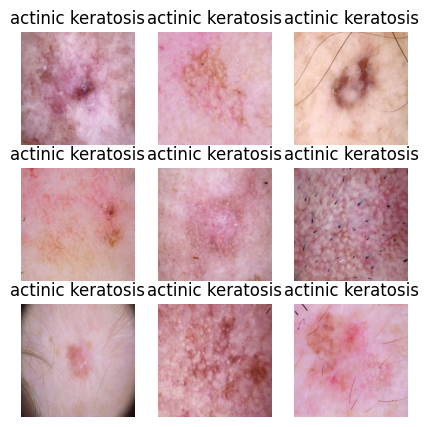

In [105]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [21]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [68]:
num_classes = 9
input_shape = (img_width, img_height, 3)

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape= input_shape),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [69]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [70]:
# View the summary of all layers
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 41, 41, 64)       

### Train the model

In [71]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 40ms/step - loss: 2.1077 - accuracy: 0.0854 - val_loss: 4.8908 - val_accuracy: 0.0000e+00
Epoch 2/20
56/56 [==============================] - 2s 33ms/step - loss: 1.8321 - accuracy: 0.1657 - val_loss: 3.7718 - val_accuracy: 0.1119
Epoch 3/20
56/56 [==============================] - 2s 31ms/step - loss: 1.7829 - accuracy: 0.2271 - val_loss: 8.9141 - val_accuracy: 0.0000e+00
Epoch 4/20
56/56 [==============================] - 2s 31ms/step - loss: 1.7838 - accuracy: 0.1557 - val_loss: 7.1179 - val_accuracy: 0.0000e+00
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.8035 - accuracy: 0.1892 - val_loss: 3.4436 - val_accuracy: 0.0000e+00
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.8317 - accuracy: 0.2483 - val_loss: 5.3067 - val_accuracy: 0.1119
Epoch 7/20
56/56 [==============================] - 2s 33ms/step - loss: 1.7409 - accuracy: 0.2561 - val_loss: 4.8270 - val_accuracy: 0.00

### Visualizing training results

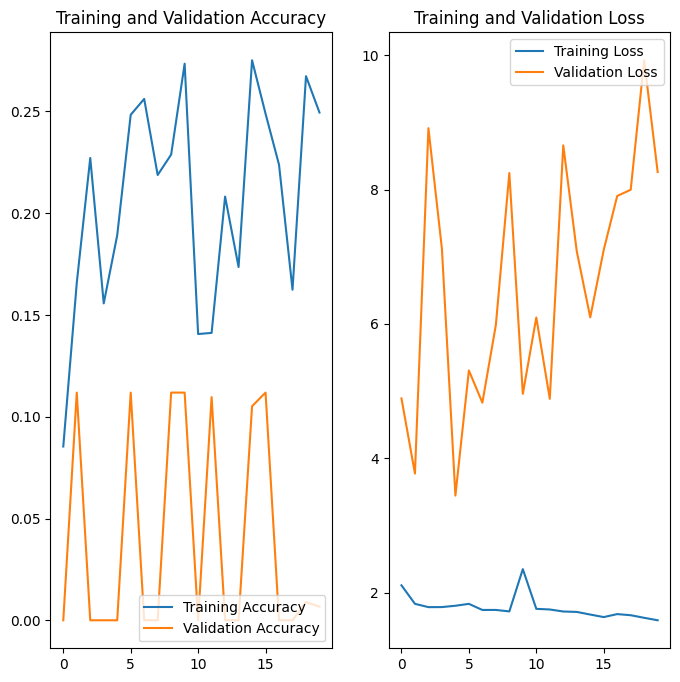

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model is overfit as per above graph.

##### As we can see in a above graph that training accuracy is high compared to testing acccuracy.

##### Also noticed that loss function is also showing huge difference

##### The overall accuracy is also very low


### Write your findings here



In [38]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

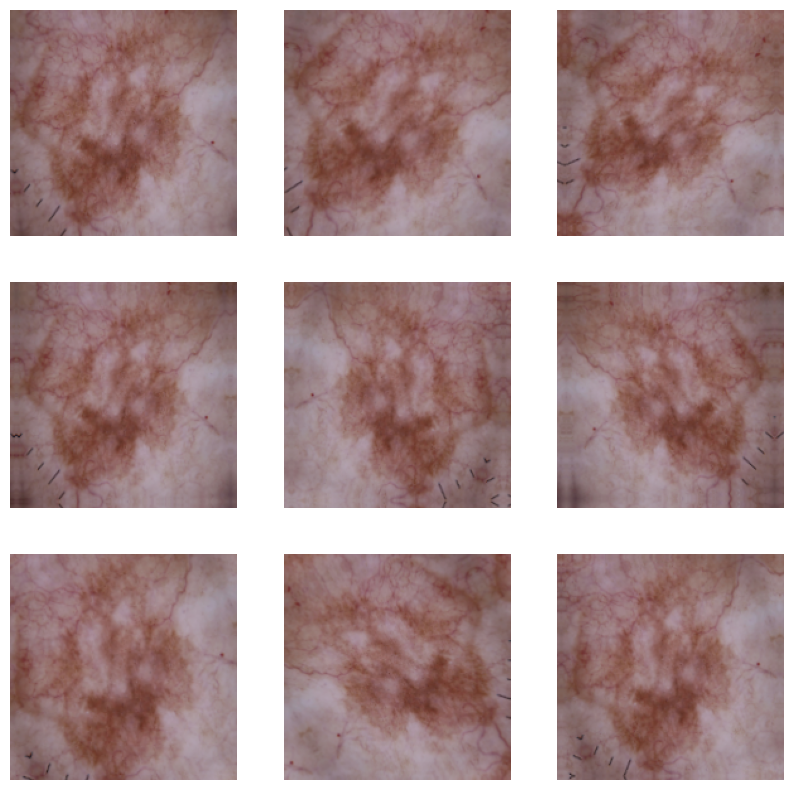

In [39]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [254]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape= input_shape),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### Compiling the model

In [255]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 41, 41, 64)      

### Training the model

In [79]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 53ms/step - loss: 2.0771 - accuracy: 0.1445 - val_loss: 7.0927 - val_accuracy: 0.0000e+00
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.9070 - accuracy: 0.2165 - val_loss: 3.1606 - val_accuracy: 0.0000e+00
Epoch 3/20
56/56 [==============================] - 3s 50ms/step - loss: 1.7243 - accuracy: 0.2204 - val_loss: 4.8438 - val_accuracy: 0.1119
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.6408 - accuracy: 0.3119 - val_loss: 4.2285 - val_accuracy: 0.0649
Epoch 5/20
56/56 [==============================] - 3s 46ms/step - loss: 1.6727 - accuracy: 0.2662 - val_loss: 4.8933 - val_accuracy: 0.1119
Epoch 6/20
56/56 [==============================] - 3s 45ms/step - loss: 1.5707 - accuracy: 0.2617 - val_loss: 6.5102 - val_accuracy: 0.1051
Epoch 7/20
56/56 [==============================] - 3s 46ms/step - loss: 1.6402 - accuracy: 0.3220 - val_loss: 4.7012 - val_accuracy: 0.0425
Epoch

### Visualizing the results

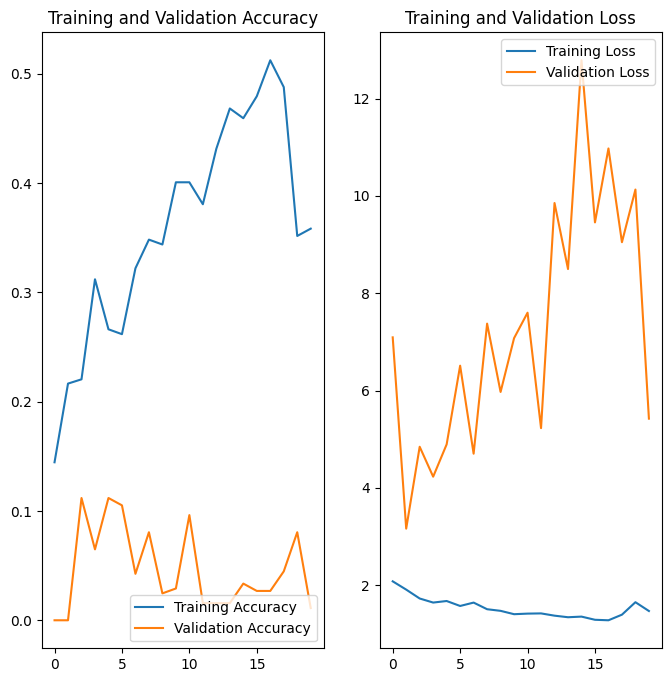

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### The tendency of overfit is still there, adding dropout have changed Traning accuraccy higher but still validation accuracy is low.
#### Model is still overfit as per current hyper parameter

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
actinic keratosis : 32
basal cell carcinoma : 0
dermatofibroma : 0
melanoma : 0
nevus : 0
pigmented benign keratosis : 0
seborrheic keratosis : 0
squamous cell carcinoma : 0
vascular lesion : 0


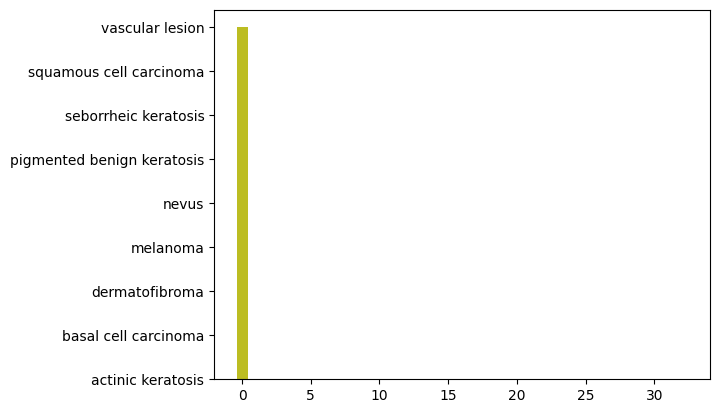

In [206]:
# ## Your code goes here.
# from numpy.random import shuffle
# import random
# filenames = list(data_dir_train.glob('*/*.jpg'))
# random.shuffle(filenames)
# filenames

ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  shuffle=True,
  validation_split=0.2,
  subset='training',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print(class_names)

count = {
  class_names[0] : 0,
  class_names[1] : 0,
  class_names[2] : 0,
  class_names[3] : 0,
  class_names[4] : 0,
  class_names[5] : 0,
  class_names[6] : 0,
  class_names[7] : 0,
  class_names[8] : 0
}
for images, labels in train_ds.take(1):
  for i in range(32):
    count[class_names[labels[i]]] += 1

for name in class_names:
  print(f"{name} : {count[name]}")
  plt.bar(count[name], name)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
Other then `actinic keratosis` all class sample are zero
#### - Which classes dominate the data in terms proportionate number of samples?
`actinic keratosis` class dominate in sample

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [13]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [221]:
print(data_dir_train)
path_to_training_dataset='/tmp/cancer/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

/tmp/cancer/Train
/tmp/cancer/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /tmp/cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4A32FB9EE0>: 100%|██████████| 500/500 [00:18<00:00, 27.76 Samples/s]


/tmp/cancer/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /tmp/cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4A3302DA00>: 100%|██████████| 500/500 [00:18<00:00, 26.75 Samples/s]


/tmp/cancer/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /tmp/cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4A32C694F0>: 100%|██████████| 500/500 [00:18<00:00, 27.14 Samples/s]


/tmp/cancer/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /tmp/cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F4A32C691C0>: 100%|██████████| 500/500 [01:34<00:00,  5.28 Samples/s]


/tmp/cancer/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /tmp/cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F4A43F47B20>: 100%|██████████| 500/500 [01:34<00:00,  5.27 Samples/s]


/tmp/cancer/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /tmp/cancer/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4AE50C4E80>: 100%|██████████| 500/500 [00:18<00:00, 27.02 Samples/s]


/tmp/cancer/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /tmp/cancer/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F4A43F2E730>: 100%|██████████| 500/500 [00:44<00:00, 11.35 Samples/s]


/tmp/cancer/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /tmp/cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4A32F6BB50>: 100%|██████████| 500/500 [00:17<00:00, 28.42 Samples/s]


/tmp/cancer/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /tmp/cancer/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4A43DE4DF0>: 100%|██████████| 500/500 [00:19<00:00, 26.04 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [225]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [236]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/tmp/cancer/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027425.jpg_1c8245d4-bd57-451a-9913-7ed40c4d680a.jpg',
 '/tmp/cancer/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0026275.jpg_ce6e56e1-0543-4cd3-a727-090b94b5ca12.jpg',
 '/tmp/cancer/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031470.jpg_81e0b79a-0cb0-4f20-83d7-29153136e822.jpg',
 '/tmp/cancer/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0024787.jpg_706fa8d6-d5cb-416f-b040-31cd9042a5ce.jpg',
 '/tmp/cancer/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025433.jpg_741e168f-ccc0-4a2b-be69-dbe7c797d78c.jpg',
 '/tmp/cancer/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030868.jpg_f82b6e95-7d46-4d60-860a-c324badd407e.jpg',
 '/tmp/cancer/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031225.jpg_b7533d30-2ab7-40b0-8665-643005306f09.jpg',
 '/tmp/cancer/Train/basal cell car

In [237]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [239]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [242]:
original_df = pd.DataFrame(columns = ['Path','Label'])
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-242-9268b636a049>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [243]:
new_df['Label'].value_counts()

basal cell carcinoma          500
vascular lesion               500
seborrheic keratosis          500
actinic keratosis             500
melanoma                      500
squamous cell carcinoma       500
nevus                         500
dermatofibroma                500
pigmented benign keratosis    500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [14]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [15]:
# data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train="/tmp/cancer/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 11 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 11 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [18]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 9
input_shape = (img_width, img_height, 3)

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape= input_shape),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [19]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                    

#### **Todo:**  Train your model

In [ ]:
epochs = 10
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
280/281 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0000e+00

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

